# Guide
1. If new instance, run the pip install initilization steps
2. Run the function definitons in each of the other sections, no need to run the acutal functions.
3. run the give_me_output function. If you want NDVI set the bool in the function call to true. If you want color set it to false. Data is stored in data folder. csv data is raw NDVI calcs for each instance. Images are NDVI and color.

# Initialization

In [1]:
%pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00


In [2]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass
import datetime as dt
from datetime import timedelta
import numpy as np

from sentinelhub import (
    SHConfig,
    DataCollection,
    filter_times,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

#from utils import plot_image

In [4]:
# DO NOT RUN
    # Only run this cell if you have not created a configuration.
    # To run, uncomment lines that are commented then put in id and
    # password when prompted. If previously ran then run the next cell
    # instead.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

#client: sh-163edb88-d7cb-45e2-9be5-b9e1688f4c0a
#secret: 3UJyAlkECznvhTBpNPjO3v7ZDPi3k8sL

Enter your SentinelHub client id··········
Enter your SentinelHub client secret··········


In [5]:
config = SHConfig("cdse")

# Catalog API

In [6]:
def catalog(aoi_bbox, time_interval, cloud_cover):
    catalog = SentinelHubCatalog(config=config)
    cloud = f"eo:cloud_cover <= {cloud_cover}"

    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=aoi_bbox,
        time=time_interval,
        filter=cloud,
        fields={"include": ["id", "properties.datetime"], "exclude": []},
    )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    time_difference = dt.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)
    print("Total number of unique results:", len(unique_acquisitions))
    return unique_acquisitions

In [ ]:
# DO NOT RUN
days = catalog(aoi_bbox, ("2022-07-01", "2022-08-01"), 100)

In [7]:
# DO NOT RUN
def catalog_request(cloud_cover, time_interval):
    catalog = SentinelHubCatalog(config=config)
    cloud = f"eo:cloud_cover <= {cloud_cover}"

    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=aoi_bbox,
        time=time_interval,
        filter=cloud,
        fields={"include": ["id", "properties.datetime"], "exclude": []},
    )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    time_difference = dt.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)
    print("Total number of unique results:", len(unique_acquisitions))
    return unique_acquisitions
    # current_day = None
    # one_per_day = []
    # for result in results:
    #     today = datetime.strptime(result['properties']['datetime'][:-1], "%Y-%m-%dT%H:%M:%S.%f")
    #     if current_day == None:
    #         current_day = today
    #         one_per_day.append(result['properties']['datetime'])
    #     elif today.date() < current_day.date():
    #         current_day = today
    #         one_per_day.append(result['properties']['datetime'])
    # print("Results on unique days:", len(one_per_day))
    # return one_per_day

In [ ]:
# DO NOT RUN
for day in days:
    print(day)

# Processing request

In [8]:
def process_and_request(aoi_bbox, aoi_size, config, days, NDVI):
    COLOR_script = """
    //VERSION=3
    function setup() {
      return {
        input: ["B04", "B03", "B02", "dataMask"],
        output: { bands: 4 }
      };
    }

    // Contrast enhance / highlight compress


    const maxR = 3.0; // max reflectance

    const midR = 0.13;
    const sat = 1.2;
    const gamma = 1.8;

    function evaluatePixel(smp) {
      const rgbLin = satEnh(sAdj(smp.B04), sAdj(smp.B03), sAdj(smp.B02));
      return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
    }

    function sAdj(a) {
      return adjGamma(adj(a, midR, 1, maxR));
    }

    const gOff = 0.01;
    const gOffPow = Math.pow(gOff, gamma);
    const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

    function adjGamma(b) {
      return (Math.pow((b + gOff), gamma) - gOffPow) / gOffRange;
    }

    // Saturation enhancement

    function satEnh(r, g, b) {
      const avgS = (r + g + b) / 3.0 * (1 - sat);
      return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
    }

    function clip(s) {
      return s < 0 ? 0 : s > 1 ? 1 : s;
    }

    //contrast enhancement with highlight compression

    function adj(a, tx, ty, maxC) {
      var ar = clip(a / maxC, 0, 1);
      return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC);
    }

    const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);
    """

    NVDI_script = '''
    //VERSION=3
    function setup() {
    return {
        input: ["B04", "B08", 'SCL'],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(samples) {
        const clouds_or_water = [0, 3, 6, 7, 8, 9, 10];
        if (clouds_or_water.includes(samples.SCL)) {
            return [0]
        }
        return [index(samples.B08, samples.B04)]
    }
    '''

    script = NVDI_script if NDVI else COLOR_script

    process_requests = []
    time_difference = dt.timedelta(hours=1)
    for timestamp in days:
        request = SentinelHubRequest(
            evalscript=script,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=aoi_bbox,
            size=aoi_size,
            config=config,
        )
        process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)

    download_requests = [request.download_list[0] for request in process_requests]

    data = client.download(download_requests)
    return data

In [ ]:
# DO NOT RUN
data = process_and_request(aoi_bbox, aoi_size, config, days, True)

In [9]:
# DO NOT RUN
def send_parallel_requests():
    %%time

    client = SentinelHubDownloadClient(config=config)

    download_requests = [request.download_list[0] for request in process_requests]

    data = client.download(download_requests)

    data[0].shape

# Save data in csv

In [10]:
def convert(data, days):
    i = 0
    for data_inst in data:
        inst = np.array(data_inst)
        df = pd.DataFrame(inst)
        df.to_csv('data/'+f'{days[i]}' + '_NDVI.csv', index=False)
        i += 1

In [ ]:
# DO NOT RUN
convert(data, days)

# Plot and save Images

In [19]:
def plot(data, days, NDVI):
    i = 0
    for image in data:
        plt.figure(figsize=(5, 5))  # Create a new figure for each image
        plt.imshow(image)
        plt.title(f"Timestamp: {days[i]}")
        plt.axis("off")  # Hide axes for a cleaner look
        ndvi = "_NDVI" if NDVI else ""
        filename = 'data/' + f"{days[i]}" + f"{ndvi}.png"  # Save using timestamp as filename
        plt.savefig(filename, bbox_inches="tight", dpi=300)  # Save with high quality
        plt.show()  # Show the figure before moving to the next one
        i+= 1

In [ ]:
# DO NOT RUN
plot(data, days, True)

# The whole thing in one cell to run

In [20]:
def give_me_output(location, time, NDVI, cloud_cover):
    config = SHConfig("cdse")
    aoi_coords_wgs84 = location
    resolution = 10
    aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
    aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
    days = catalog(aoi_bbox, time, cloud_cover)
    data = process_and_request(aoi_bbox, aoi_size, config, days, NDVI)
    if NDVI:
        convert(data, days)
        plot(data, days, NDVI)
    else:
        print(len(data))
        plot(data, days, NDVI)

Total number of results: 7
Total number of unique results: 7
7


FileNotFoundError: [Errno 2] No such file or directory: 'content/data/2022-08-01 05:25:24.580000+00:00.png'

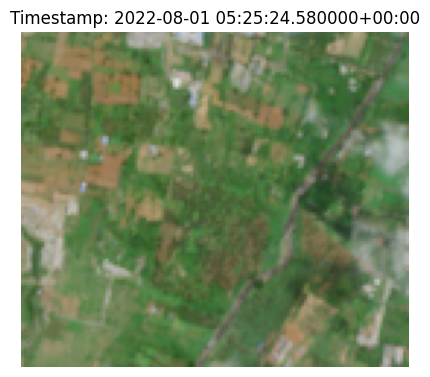

In [21]:
#give_me_output([-71.186446,42.321809,-71.167521,42.332691], ("2022-06-01", "2022-07-01"), True, 100)
give_me_output([77.430741,12.848126,77.443058,12.858419], ("2022-8-01", "2022-9-01"), False, 100)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
